In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from cuml import KMeans
from cuml.metrics.cluster import silhouette_score
import time

In [2]:
df = pd.read_csv("enron_data_fraud_labeled.csv")
#drop class label
df=df.drop(['Label'],axis=1)
df.head()

/tmp/ipykernel_249345/1780134095.py:1: DtypeWarning: Columns (7,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("enron_data_fraud_labeled.csv")


,Folder-User,Folder-Name,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,...,Attendees,Re,Source,Mail-ID,POI-Present,Suspicious-Folders,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,maildir,arnold-j,<17334447.1075857585446.JavaMail.evans@thyme>,"Thu, 16 Nov 2000 09:30:00 -0800 (PST)",msagel@home.com,jarnold@enron.com,Status,1.0,text/plain; charset=ANSI_X3.4-1968,7bit,...,,,Enron Data,b399fa1ba5ec06ccf8ead1049a53be981d0ebb39ee2c94...,False,False,External,18.0,False,False
1,maildir,arnold-j,<19171686.1075857585034.JavaMail.evans@thyme>,"Fri, 8 Dec 2000 05:05:00 -0800 (PST)",slafontaine@globalp.com,john.arnold@enron.com,re:summer inverses,1.0,text/plain; charset=us-ascii,7bit,...,,,Enron Data,84b07d7a0a17b545896f670f92d200e86843c2796147d9...,False,False,External,4.0,True,False
2,maildir,arnold-j,<29887033.1075857630725.JavaMail.evans@thyme>,"Tue, 15 May 2001 09:43:00 -0700 (PDT)",iceoperations@intcx.com,"icehelpdesk@intcx.com, internalmarketing@intcx...",The WTI Bullet swap contracts,1.0,text/plain; charset=us-ascii,7bit,...,,,Enron Data,f7482dd06262f46d341e733aa0c2fb55cb1e257ea153d0...,False,False,External,3.0,True,False
3,maildir,arnold-j,<2526360.1075857584903.JavaMail.evans@thyme>,"Mon, 11 Dec 2000 23:52:00 -0800 (PST)",klarnold@flash.net,john.arnold@enron.com,Fwd: NYTimes.com Article: Suspended Rabbi Quit...,1.0,text/plain; charset=us-ascii,7bit,...,,,Enron Data,25441e5a837fefda50527731fdbcdf0848663be82cd1ce...,False,False,External,9.0,False,True
4,maildir,arnold-j,<30102065.1075857630952.JavaMail.evans@thyme>,"Mon, 14 May 2001 23:59:00 -0700 (PDT)",soblander@carrfut.com,soblander@carrfut.com,daily charts and matrices as hot links 5/15,1.0,text/plain; charset=us-ascii,7bit,...,,,Enron Data,c2995c6a70b953ee66c21d8a509ebfbfaca28277917beb...,False,False,External,352.0,False,False


In [3]:
df=df.drop(['Folder-User','Mime-Version','Message-ID','Date','From','To','Subject','X-From','X-cc','X-Folder','Body','Cc','Bcc','Re','Source','Mail-ID',
            'Suspicious-Folders'], axis=1)
df.head()

,Folder-Name,Content-Type,Content-Transfer-Encoding,X-To,X-bcc,X-Origin,X-FileName,Time,Attendees,POI-Present,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,arnold-j,text/plain; charset=ANSI_X3.4-1968,7bit,"""John Arnold"" <jarnold@enron.com>",NaN,Arnold-J,Jarnold.nsf,,,False,External,18.0,False,False
1,arnold-j,text/plain; charset=us-ascii,7bit,John.Arnold@enron.com,NaN,Arnold-J,Jarnold.nsf,,,False,External,4.0,True,False
2,arnold-j,text/plain; charset=us-ascii,7bit,"**ICEHELPDESK <**ICEHELPDESK@intcx.com>, **Int...",NaN,Arnold-J,Jarnold.nsf,,,False,External,3.0,True,False
3,arnold-j,text/plain; charset=us-ascii,7bit,john.arnold@enron.com,NaN,Arnold-J,Jarnold.nsf,,,False,External,9.0,False,True
4,arnold-j,text/plain; charset=us-ascii,7bit,soblander@carrfut.com,NaN,Arnold-J,Jarnold.nsf,,,False,External,352.0,False,False


In [4]:
df=df.drop(['X-bcc'], axis=1).dropna()
df.head()

,Folder-Name,Content-Type,Content-Transfer-Encoding,X-To,X-Origin,X-FileName,Time,Attendees,POI-Present,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,arnold-j,text/plain; charset=ANSI_X3.4-1968,7bit,"""John Arnold"" <jarnold@enron.com>",Arnold-J,Jarnold.nsf,,,False,External,18.0,False,False
1,arnold-j,text/plain; charset=us-ascii,7bit,John.Arnold@enron.com,Arnold-J,Jarnold.nsf,,,False,External,4.0,True,False
2,arnold-j,text/plain; charset=us-ascii,7bit,"**ICEHELPDESK <**ICEHELPDESK@intcx.com>, **Int...",Arnold-J,Jarnold.nsf,,,False,External,3.0,True,False
3,arnold-j,text/plain; charset=us-ascii,7bit,john.arnold@enron.com,Arnold-J,Jarnold.nsf,,,False,External,9.0,False,True
4,arnold-j,text/plain; charset=us-ascii,7bit,soblander@carrfut.com,Arnold-J,Jarnold.nsf,,,False,External,352.0,False,False


In [5]:
le = LabelEncoder()
categorical = ['Folder-Name','Content-Type','Content-Transfer-Encoding','X-To','X-Origin','X-FileName','Time','Attendees','POI-Present','Sender-Type',
               'Low-Comm','Contains-Reply-Forwards']
for variable in categorical:
    df[variable] = le.fit_transform(df[variable])
df.head()

,Folder-Name,Content-Type,Content-Transfer-Encoding,X-To,X-Origin,X-FileName,Time,Attendees,POI-Present,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,1,1,1,2988,4,64,0,0,0,0,18.0,0,0
1,1,2,1,36621,4,64,0,0,0,0,4.0,1,0
2,1,2,1,10480,4,64,0,0,0,0,3.0,1,0
3,1,2,1,68130,4,64,0,0,0,0,9.0,0,1
4,1,2,1,71437,4,64,0,0,0,0,352.0,0,0


In [6]:
cols = df.columns
ms = MinMaxScaler()
df = ms.fit_transform(df)
df = pd.DataFrame(df, columns=[cols])
df.head()

,Folder-Name,Content-Type,Content-Transfer-Encoding,X-To,X-Origin,X-FileName,Time,Attendees,POI-Present,Sender-Type,Unique-Mails-From-Sender,Low-Comm,Contains-Reply-Forwards
0,0.006849,0.5,0.333333,0.041302,0.015748,0.151659,0.0,0.0,0.0,0.0,0.003281,0.0,0.0
1,0.006849,1.0,0.333333,0.506192,0.015748,0.151659,0.0,0.0,0.0,0.0,0.000729,1.0,0.0
2,0.006849,1.0,0.333333,0.144859,0.015748,0.151659,0.0,0.0,0.0,0.0,0.000547,1.0,0.0
3,0.006849,1.0,0.333333,0.941724,0.015748,0.151659,0.0,0.0,0.0,0.0,0.001641,0.0,1.0
4,0.006849,1.0,0.333333,0.987435,0.015748,0.151659,0.0,0.0,0.0,0.0,0.064163,0.0,0.0


In [7]:
silhouette_coefficient = []
for i in range(2,31):
    kmeanspp = KMeans(n_clusters=i, init='k-means++', max_iter = 300, n_init = 10, random_state=0)
    kmeanspp.fit(df)
    silhouette_coefficient.append(silhouette_score(df, kmeanspp.labels_))
    print("k=%d done" % i)

k=2 done
k=3 done
k=4 done
k=5 done
k=6 done
k=7 done
k=8 done
k=9 done
k=10 done
k=11 done
k=12 done
k=13 done
k=14 done
k=15 done
k=16 done
k=17 done
k=18 done
k=19 done
k=20 done
k=21 done
k=22 done
k=23 done
k=24 done
k=25 done
k=26 done
k=27 done
k=28 done
k=29 done
k=30 done


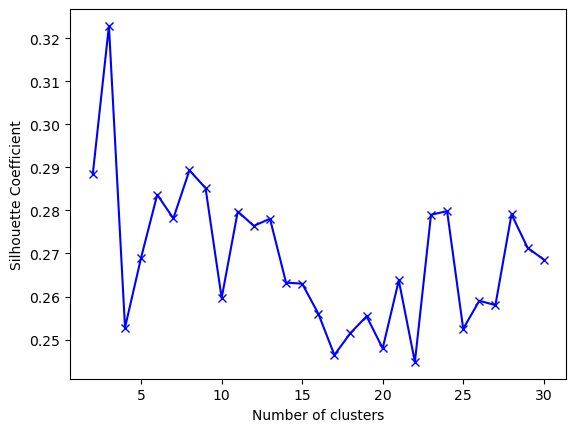

In [9]:
plt.plot(range(2,31), silhouette_coefficient, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

In [7]:
#determine time taken for k means++
kmeanspp = KMeans(n_clusters=4, init='k-means++', max_iter = 300, n_init = 10, random_state=0)
start_time = time.time()
kmeanspp.fit(df)
end_time = time.time()
end_time-start_time

1.2271926403045654

In [8]:
#sum of squared L2 distance
kmeanspp.inertia_

194178.9380472282

In [9]:
#silhouette coefficient
silhouette_score(df, kmeanspp.labels_)

0.25278406588661845